# Collaboration and Competition - Project

---

# Introduction


# Implementation

This project implements a variant of the `MADDPG` algorithm described in [1], which is a modification of `DDPG` [2] for multi-agent scenarios. 

The DDPG algorithm is a model-free, off-policy gradient based reinforcement learning algorithm where two deep learning networks are employed:
* The `actor` network learns a policy from states.
* The `critic` network learns an estimate of the value-function of a state-action pair. The critic estimates are used to guide the learning of the `actor`.

Because learning is off-policy, the above networks are duplicated as local and target. DDPG uses a "soft-update" method to update the target network, which is a weighted update of the network weights where the local network weights contribute by a factor `TAU`, while the target network contributes with `1-TAU`.

As with other deep RL methods, DDPG makes use of a replay buffer. 

## MADDPG

In this project I modify the `DDPG` implementation of the previous P2 assignment in order to satisfy the assumptions of `MADDPG`:
* agents can share information while training their respective policies.
* however at runtime, each agent acts independently, without knowledge of each other.

To that end, we will make the following modifications:
* During training each agent has access to a **shared** replay buffer.

## Hyper Parameters

```python
BUFFER_SIZE = 100000    # replay buffer size
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.9             # discount factor
TAU = 0.001             # for soft update of target parameters
LR_ACTOR = 0.001        # learning rate of the actor 
LR_CRITIC = 0.001       # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

N_EPS = 10000           # how many episodes
MAX_T = 1000            # max time steps in each episode

UPDATE_EVERY = 1        # num of timesteps to run learning
LEARN_ROUNDS = 1        # repeat learning (sample from memory + backprop) this many times 

LAYER1_NODES=128        # hidden layer 1 - # units 
LAYER2_NODES=64         # hidden layer 2 - # units

NOISE_THETA=0.1         # theta parameter in OU noise process
NOISE_SIGMA=0.1         # sigma parameter in OU noise process

BATCH_NORM = True       # use batch normalization in critic
STOP_AT = 0.5           # stop training when rolling mean score reaches this value 

NUM_AGENTS = 2

SEED = 13
```

## Observations

While in past experiments it was useful to tune the frequency (in steps) and number of learn updates to influence the speed of learning, this experiment agrees with [4] in that the most expedient training regime was to run backprop on once for each agent at every time step. Thus we set our hyper parameters to:

```
UPDATE_EVERY = 1        # num of timesteps to run learning
LEARN_ROUNDS = 1        # repeat learning (sample from memory + backprop) this many times 
```

In our implementation the solution converged in about 800 episodes:

```
Episode 0	Average of Max Scores: 0.000 Mean episode len: 14.00; Sum score: 0.00
Episode 100	Average of Max Scores: 0.012 Mean episode len: 16.85; Sum score: 1.18
Episode 200	Average of Max Scores: 0.038 Mean episode len: 22.20; Sum score: 3.81
Episode 300	Average of Max Scores: 0.008 Mean episode len: 16.01; Sum score: 0.80
Episode 400	Average of Max Scores: 0.013 Mean episode len: 16.76; Sum score: 1.27
Episode 500	Average of Max Scores: 0.072 Mean episode len: 30.45; Sum score: 7.18
Episode 600	Average of Max Scores: 0.120 Mean episode len: 48.78; Sum score: 12.01
Episode 700	Average of Max Scores: 0.137 Mean episode len: 53.91; Sum score: 13.73
Episode 800	Average of Max Scores: 0.465 Mean episode len: 179.43; Sum score: 46.46
Episode 805	Average of Max Scores: 0.505
```

![img](trend-raw.png)

Smoothed out version indicating 100-eps rolling mean:

![img](trend-smooth.png)

## Further Work

There are other opportunities for improvement described in the `MADDPG` paper, namely:
* The use of information from both agents while training the critic network.
* Implement agents with policy ensembles.

In addition, a more systematic hyper parameter tuning may yield posiitve results, as well as the application of other RL methods for continous spaces, like the ones benchmarked in [3].


# Instructions

1. `git clone` this repo: https://github.com/bohana/udacity-deep-rl.git
1. `pip install` the following packages: `numpy`, `matplotlib`, `pandas`, `pytorch`, `unityagents (0.4.0)`
1. Download the Unity `Tennis` environment per project instructions (I used the Linux version found [here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P3/Tennis/Tennis_Linux.zip)), and unzip it in the repo's `p3_collab-compet` directory.
1. Run this notebook.

## Project Files

This repo contains the following files under the `p2_control` directory:

```
P3_Collab_Compete_Tennis.ipynb  - notebook with entire project implementation
checkpoint_ag0_actor.pth        - actor network params - agent 1 
checkpoint_ag0_critic.pth       - cricit network params - agent 1 
checkpoint_ag1_actor.pth        - actor network params - agent 2
checkpoint_ag1_critic.pth       - critic network params - agent 2
README.md                       - this file.
```


# References

[1] - Multi-Agent Actor-Critic for Mixed Cooperative-Competitive Environments (Lowe et al 2017) - https://papers.nips.cc/paper/7217-multi-agent-actor-critic-for-mixed-cooperative-competitive-environments.pdf

[2] - Continous Control with Deep Reinforcement Learning (Lilicrap et al 2015) https://arxiv.org/pdf/1509.02971.pdf

[3] - Benchmarking Deep Reinforcement Learning for Continuous Control (Duan et al 2016) https://arxiv.org/pdf/1604.06778.pdf

[4] - https://towardsdatascience.com/training-two-agents-to-play-tennis-8285ebfaec5f

---

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64", no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
            
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


# Assignment Starts Here

## Approach

We will modify the `DDPG` implementation of the previous P2 assignment in order to satisfy the assumptions of `MADDPG`:
* agents can share information while training their respective policies.
* however at runtime, each agent acts independently, without knowledge of each other.

To that end, we will make the following modifications:
* During training each agent has access to a **shared** replay buffer.


### Define Actor and critic Networks

In [6]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

In [7]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        #state = self.bn(state)
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        
        # the output for each state is a continous function expressed by tanh non linearilty
        return torch.tanh(self.fc3(x))

In [8]:
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units + action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.bn = nn.BatchNorm1d(state_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        if BATCH_NORM:
            state = self.bn(state)
            
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### Replay Buffer and OU Noise Process

In [9]:
import numpy as np
import random
import copy
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim

In [10]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### OU Noise

The `OUNoise` class implements a random noise process based on Ornstein-Uhlenbeck process. The core idea is to provide randomness correlated with past randomly generated input.

* See also: https://www.quora.com/Why-do-we-use-the-Ornstein-Uhlenbeck-Process-in-the-exploration-of-DDPG


In [11]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = seed
        np.random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(len(x))
        self.state = x + dx
        return self.state

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, buffer, random_seed, fc1_units=64, fc2_units=64):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed,
                                 fc1_units=fc1_units, fc2_units=fc2_units).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed,
                                  fc1_units=fc1_units, fc2_units=fc2_units).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(),
                                          lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed,
                                   fc1_units=fc1_units, fc2_units=fc2_units).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed,
                                    fc1_units=fc1_units, fc2_units=fc2_units).to(device)
        
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(),
                                           lr=LR_CRITIC,
                                           weight_decay=WEIGHT_DECAY)
        
        # make local and target parameters identical
        for target_param, local_param in zip(self.actor_target.parameters(), self.actor_local.parameters()):
            target_param.data.copy_(local_param.data)

        for target_param, local_param in zip(self.critic_target.parameters(), self.critic_local.parameters()):
            target_param.data.copy_(local_param.data)

        # Noise process
        self.noise = OUNoise(action_size, random_seed, theta=NOISE_THETA, sigma=NOISE_SIGMA)

        # Replay memory - use shared cache passed as argument
        self.memory = buffer
        
        self.train_counter = 0
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)
        self.train_counter += 1

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE and (self.train_counter >= UPDATE_EVERY):
            for _ in range(LEARN_ROUNDS):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)
            self.train_counter = 0

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
            
        self.actor_local.train()

        if add_noise:
            action += self.noise.sample()
            
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

Create a wrapper class to execute a multi-agent experiment:

In [13]:
class MADDPGAgents:
    def __init__(self, agents):
        self.agents = agents
    
    def reset(self):
        for agent in self.agents:
            agent.reset()
    
    def act(self, states):
        actions = [agent.act(state) for agent, state in zip(self.agents, states)]
        return actions
    
    def step(self, states, actions, rewards, next_states, dones):
        for agent, state, action, reward, next_state, done in zip(self.agents, states, actions,
                                                                  rewards, next_states, dones):
            agent.step(state, action, reward, next_state, done)
    
    def save(self):
        for n, ag in enumerate(self.agents):
            torch.save(ag.actor_local.state_dict(), 'checkpoint_ag{}_actor.pth'.format(n))
            torch.save(ag.critic_local.state_dict(), 'checkpoint_ag{}_critic.pth'.format(n))
            

Noting that for scoring, we use the same approach described in the Udacity "benchmark implementation", which states:

```
maximum score over both agents, for each episode, and the orange line shows the average score (after taking the maximum over both agents) over the next 100 episodes.
```

In [14]:
def maddpg_unity(env, mad_agent, n_eps=1000, max_t=1000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    eps_deque = deque(maxlen=print_every)
    
    scores = []
    
    for eps in range(n_eps):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        episode_scores = np.zeros(NUM_AGENTS)
        
        mad_agent.reset()

        for t in range(max_t):     
            actions = mad_agent.act(states)
            
            # execute actions in unity
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            
            # learn
            mad_agent.step(states, actions, rewards, next_states, dones)
            
            states = next_states
            episode_scores += np.array(rewards)
            
            if np.any(dones):
                break 
        
        score = episode_scores.max()
        scores_deque.append(score)
        scores.append(score)
        eps_deque.append(t + 1)
        
        print('\rEpisode {}\tAverage of Max Scores: {:.3f}'.format(eps,
                                                                   np.mean(scores_deque)), end="")
        
        if eps % print_every == 0:
            print('\rEpisode {}\tAverage of Max Scores: {:.3f}'.format(eps, np.mean(scores_deque)), end="")
            print(' Mean episode len: {:.2f}; Sum score: {:.2f}'.format(np.mean(eps_deque), np.sum(scores_deque)))
            
        if np.mean(scores_deque) >= STOP_AT:
            break
    
    mad_agents.save()
    return scores

### Hyper Parameters

In [15]:
BUFFER_SIZE = 100000    # replay buffer size
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.9           # discount factor
TAU = 0.001            # for soft update of target parameters
LR_ACTOR = 0.001      # learning rate of the actor 
LR_CRITIC = 0.001     # learning rate of the critic
WEIGHT_DECAY = 0       # L2 weight decay

N_EPS = 10000
MAX_T = 1000

UPDATE_EVERY = 1       # num of timesteps to run learning
LEARN_ROUNDS = 1       # repeat learning (sample from memory + backprop) this many times 

LAYER1_NODES=128
LAYER2_NODES=64

NOISE_THETA=0.1
NOISE_SIGMA=0.1


BATCH_NORM = True
STOP_AT = 0.5

NUM_AGENTS = 2

SEED = 13

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
import time

print('Your device:', device)
print('- training starts', time.asctime())

shared_buffer = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, SEED)

# create list of agents using shared buffer
agents = [Agent(state_size=state_size,
                action_size=action_size,
                buffer=shared_buffer,
                random_seed=SEED,
                fc1_units=LAYER1_NODES,
                fc2_units=LAYER2_NODES) for _ in range(NUM_AGENTS)]

mad_agents = MADDPGAgents(agents)

scores = maddpg_unity(env, mad_agents,
                      n_eps=N_EPS,
                      max_t=MAX_T,
                      print_every=100)

print('- training end', time.asctime())

Your device: cuda:0
- training starts Mon Mar 18 07:24:36 2019
Episode 0	Average of Max Scores: 0.000 Mean episode len: 14.00; Sum score: 0.00
Episode 100	Average of Max Scores: 0.012 Mean episode len: 16.85; Sum score: 1.18
Episode 200	Average of Max Scores: 0.038 Mean episode len: 22.20; Sum score: 3.81
Episode 300	Average of Max Scores: 0.008 Mean episode len: 16.01; Sum score: 0.80
Episode 400	Average of Max Scores: 0.013 Mean episode len: 16.76; Sum score: 1.27
Episode 500	Average of Max Scores: 0.072 Mean episode len: 30.45; Sum score: 7.18
Episode 600	Average of Max Scores: 0.120 Mean episode len: 48.78; Sum score: 12.01
Episode 700	Average of Max Scores: 0.137 Mean episode len: 53.91; Sum score: 13.73
Episode 800	Average of Max Scores: 0.465 Mean episode len: 179.43; Sum score: 46.46
Episode 805	Average of Max Scores: 0.505- training end Mon Mar 18 07:37:02 2019


In [17]:
all_scores = scores

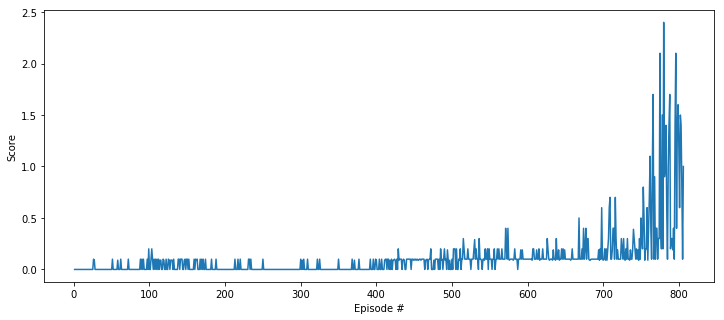

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.figure.set_size_inches(12, 5)

plt.plot(np.arange(1, len(scores)+1),
         scores)

plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
ax.figure.savefig('trend-raw.png')

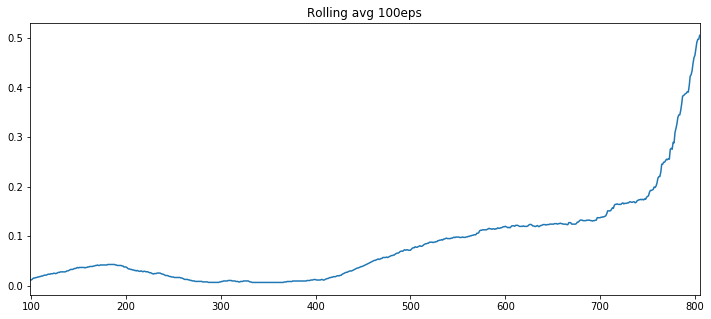

In [21]:
import pandas as pd


s = pd.Series(scores)
r = s.rolling(100)

ax = r.mean().dropna().plot(figsize=(12, 5), title='Rolling avg 100eps')
ax.figure.savefig('trend-smooth.png')